# WAMLAP Phase 2: The Data-Driven Baseline (FCNN)

In this notebook, we will build, train, and evaluate a simple Fully Connected Neural Network (FCNN) to learn the behavior of a simple harmonic oscillator purely from the data we generated in the previous step. This model will serve as our baseline for comparison against more advanced models later.

In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- TensorFlow ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers


print("All libraries imported.")

All libraries imported.


# 1. Load and Inspect the Data

The first step is to load the ground truth data we generated in the previous notebook. We'll use Pandas to read the CSV file and then create a quick plot to ensure the data has loaded correctly and looks as we expect.

Data loaded successfully. Here's a summary and the first 5 rows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      1000 non-null   float64
 1   position  1000 non-null   float64
 2   velocity  1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


   time  position  velocity
0  0.00  1.000000  0.000000
1  0.05  0.998750 -0.049979
2  0.10  0.995004 -0.099833
3  0.15  0.988772 -0.149441
4  0.20  0.980072 -0.198681


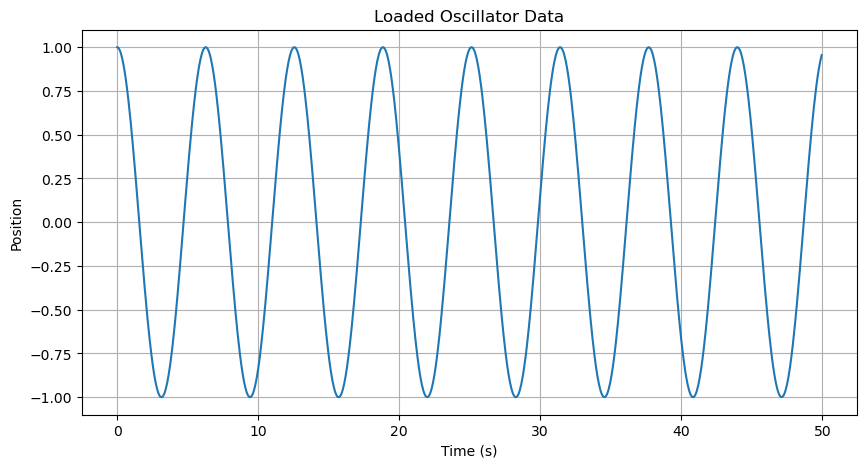

In [2]:
# --- 1. Load the data ---
# IMPORTANT: Replace this with the actual name of your generated data file.
filename = "2025-10-09_121653_sho_zeta0p0_omega1p0.csv" # <-- UPDATE THIS
filepath = f"../data/processed/{filename}"

# Read the data into a DataFrame
df = pd.read_csv(filepath)

# --- 2. Inspect the data ---
print("Data loaded successfully. Here's a summary and the first 5 rows:")
df.info()
print("\n") # Add a newline for better spacing
print(df.head())


# --- 3. Quick Visualization ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['position'])
plt.title('Loaded Oscillator Data')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.grid(True)
plt.show()

# 2. Prepare Data for Model Training 

Neural networks require data to be structured into **inputs (features)** and **outputs (labels)**.

-   **Inputs (X):** The `time` column. This is what we will give the model to make a prediction.
-   **Outputs (y):** The `position` column. This is what we want the model to learn to predict.

We also need to ensure the data is in the correct shape (a 2D array) for TensorFlow.

In [3]:
# Select our features (X) and labels (y)
X = df[['time']].values
y = df[['position']].values

# The double brackets on [['time']] ensure X is a 2D array (e.g., [[0], [0.05], ...])
# which is what TensorFlow/Keras expects.

print(f"Features shape (X): {X.shape}")
print(f"Labels shape (y): {y.shape}")

Features shape (X): (1000, 1)
Labels shape (y): (1000, 1)


# 3. Build the Neural Network Model 

Now we'll define our model's architecture using TensorFlow's Keras API. We'll use a `Sequential` model, which is a straightforward stack of layers.

Our model will have:
-   Two hidden **`Dense`** layers with a `tanh` activation function. These layers are responsible for learning the complex patterns in the data. `tanh` is often a good choice for oscillating functions.
-   One final **`Dense`** layer with a single neuron, which will output our final prediction for the oscillator's position.

After defining the structure, we'll **compile** the model, configuring it with an `optimizer` and a `loss` function.

In [4]:
# --- 1. Define the model architecture ---
model = keras.Sequential([
    keras.layers.Dense(128, activation='tanh', input_shape=[1]),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(1)
])

# --- 2. Compile the model ---
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# --- 3. Display the model summary ---
model.summary()

/Users/jamesmclean/miniforge3/envs/WAMLAP/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-09 14:38:16.906154: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-10-09 14:38:16.906179: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-10-09 14:38:16.906186: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-10-09 14:38:16.906201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-09 14:38:16.906212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.c

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,897 (66.00 KB)

 Trainable params: 16,897 (66.00 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Train the Neural Network 

Now we'll train our compiled model using the `model.fit()` function. This is where the learning happens. The model will look at the `(X, y)` data pairs repeatedly and the `adam` optimizer will adjust the internal weights to minimize the `mean_squared_error` loss.

-   **Epochs:** An "epoch" is one complete pass through the entire training dataset. We'll train for many epochs to give the model enough time to learn.
-   **Validation Split:** We'll automatically set aside 20% of the data for validation. The model won't train on this data; it will only use it to check its performance at the end of each epoch, which helps us see how well it's generalizing.

We will store the output of the training process in a `history` object so we can plot the learning curve.

Starting model training...


2025-10-09 14:38:17.326701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Model training complete.


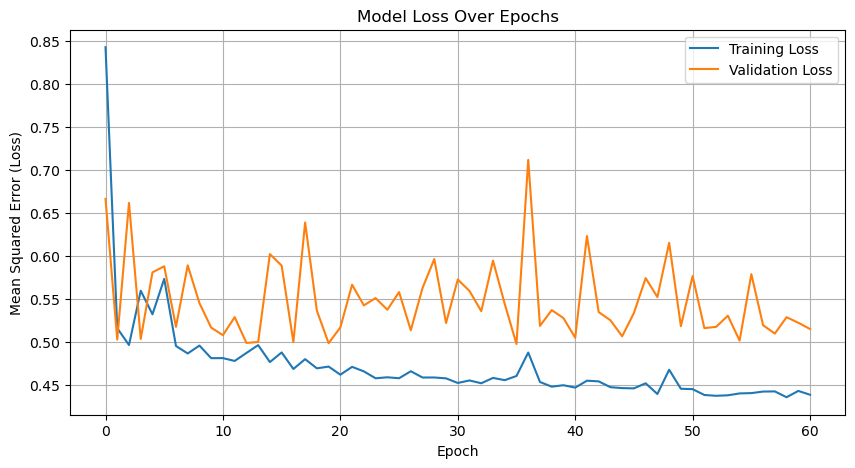

In [5]:


# --- 1. Configure the Early Stopping callback ---
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    # Rule of thumb: A value between 10-50 is a good start.
    # We'll use 25 to be patient enough for fluctuations but not wasteful.
    patience=25,
    #"restore_best_weights=True"  It ensures we always keep the model from its best-performing epoch
    restore_best_weights=True
)

# --- 2. Train the model ---
print("Starting model training...")
history = model.fit(
    X,
    y,
    epochs=500,           # Max epochs; will likely stop earlier
    validation_split=0.2,
    verbose=0,            # Standard per-epoch progress bar
    callbacks=[early_stopping_callback] # Activate early stopping
)
print("Model training complete.")

# --- 3. Plot the training history ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# 5. Improving the Model with Regularization

After our first training run, the loss curve showed classic signs of **overfitting**: the training loss decreased steadily, but the validation loss was erratic and failed to improve. This indicates the model was memorizing the training data instead of learning the general physical pattern.

To fix this, we are introducing two **regularization** techniques:
1.  **L2 Regularization**: This adds a small penalty for large weight values, encouraging the model to find simpler, more general solutions.
2.  **Dropout**: This randomly deactivates neurons during training, forcing the network to learn more robust and less co-dependent features.

In [6]:

# --- 1. Define the regularized model architecture ---
model = keras.Sequential([
    # Input layer with L2 regularization and Dropout
    layers.Dense(
        128,
        activation='tanh',
        kernel_regularizer=regularizers.l2(0.001), # Add L2 penalty
        input_shape=[1]
    ),
    layers.Dropout(0.2), # Randomly drop 20% of neurons during training

    # Second hidden layer with L2 regularization and Dropout
    layers.Dense(
        128,
        activation='tanh',
        kernel_regularizer=regularizers.l2(0.001) # Add L2 penalty
    ),
    layers.Dropout(0.2),

    # Output layer
    layers.Dense(1)
])

# --- 2. Compile the model ---
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# --- 3. Display the model summary ---
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,897 (66.00 KB)

 Trainable params: 16,897 (66.00 KB)

 Non-trainable params: 0 (0.00 B)

Starting model training...
Model training complete.


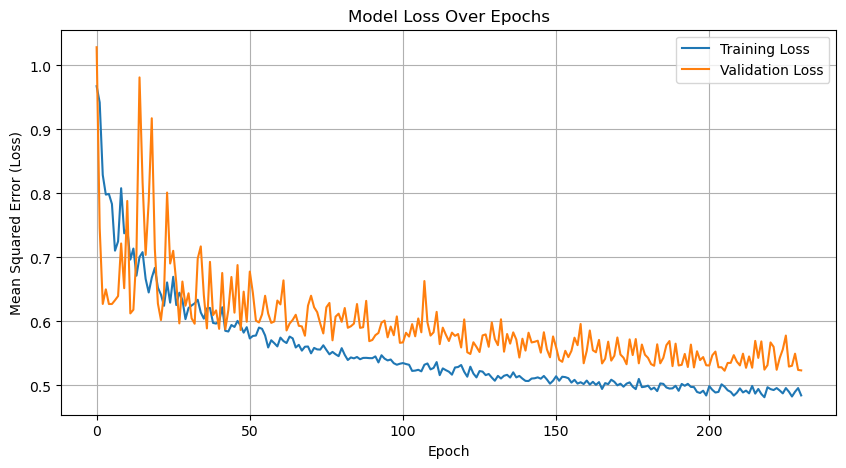

In [7]:


# --- 1. Configure the Early Stopping callback ---
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    # Rule of thumb: A value between 10-50 is a good start.
    # We'll use 25 to be patient enough for fluctuations but not wasteful.
    patience=25,
    #"restore_best_weights=True"  It ensures we always keep the model from its best-performing epoch
    restore_best_weights=True
)

# --- 2. Train the model ---
print("Starting model training...")
history = model.fit(
    X,
    y,
    epochs=500,           # Max epochs; will likely stop earlier
    validation_split=0.2,
    verbose=0,            # Standard per-epoch progress bar
    callbacks=[early_stopping_callback] # Activate early stopping
)
print("Model training complete.")

# --- 3. Plot the training history ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# 6. Diagnosis and Feature Engineering

After making the model more powerful and adding regularization, our training is much more stable. However, the loss curve analysis shows that the model's performance has hit a plateau at a high error value. This is a classic sign of **high bias**.

The model has learned everything it can from the single `time` feature and cannot improve further. The problem isn't the model's architecture anymore; it's the information we're giving it.

**The Solution:** We will perform **feature engineering** to create smarter, more informative inputs. By creating new cyclical features (`sin(time)` and `cos(time)`), we give the model the fundamental building blocks of oscillation, making the learning task dramatically easier.


In [8]:
# --- Feature Engineering ---
# Create new features that are inherently cyclical.
df['sin_time'] = np.sin(df['time'])
df['cos_time'] = np.cos(df['time'])

print("Created new sin(time) and cos(time) features.")
df.head()

Created new sin(time) and cos(time) features.


,time,position,velocity,sin_time,cos_time
0,0.00,1.000000,0.000000,0.000000,1.000000
1,0.05,0.998750,-0.049979,0.049979,0.998750
2,0.10,0.995004,-0.099833,0.099833,0.995004
3,0.15,0.988772,-0.149441,0.149438,0.988771
4,0.20,0.980072,-0.198681,0.198669,0.980067


In [9]:
# Select our NEW features (X) and labels (y)
X = df[['sin_time', 'cos_time']].values
y = df[['position']].values

print(f"Features shape (X): {X.shape}")
print(f"Labels shape (y): {y.shape}")

Features shape (X): (1000, 2)
Labels shape (y): (1000, 1)


# 7. Updated Model Architecture

This cell defines our updated baseline model, incorporating the lessons learned from previous iterations:

1.  **Initial Model (Underfit):** Our first simple model (64 neurons) had high loss, failing to capture the data's complexity.
2.  **Increased Capacity (Overfit):** We increased the model's power (128 neurons), but this led to overfitting, where the model memorized the training data but failed to generalize.
3.  **Regularization:** We introduced **L2 Regularization** and **Dropout** to combat overfitting, forcing the model to learn more robust patterns.
4.  **Feature Engineering:** Finally, to solve the underlying problem of high bias, we've updated the `input_shape` from `[1]` to `[2]` to accept our new, more informative features (`sin_time` and `cos_time`).

In [10]:
# --- 1. Define the final, regularized model architecture ---
model = keras.Sequential([
    # Input layer and first hidden layer.
    # Note the input_shape is now [2] to accept sin(time) and cos(time).
    layers.Dense(
        128,
        activation='tanh',
        kernel_regularizer=regularizers.l2(0.), # L2 penalty to prevent large weights
        input_shape=[2]
    ),
    # Dropout layer to randomly disable 20% of neurons and prevent co-adaptation.
    layers.Dropout(0.2),

    # Second hidden layer
    layers.Dense(
        128,
        activation='tanh',
        kernel_regularizer=regularizers.l2(0.)
    ),
    layers.Dropout(0.2),

    # Output layer with a single neuron to predict the final 'position' value.
    layers.Dense(1)
])

# --- 2. Compile the model ---
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# --- 3. Display the model summary ---
# This shows the architecture and confirms the input shape is (None, 2).
model.summary()


/Users/jamesmclean/miniforge3/envs/WAMLAP/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,025 (66.50 KB)

 Trainable params: 17,025 (66.50 KB)

 Non-trainable params: 0 (0.00 B)

# 8. Evaluate the Updated Model and Visualize Predictions

 We will use the trained model to make predictions on our entire dataset and then plot these predictions against the "ground truth" data.

A successful model will produce a curve that closely overlaps the original data, showing that it has learned the underlying physical pattern of the harmonic oscillator.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


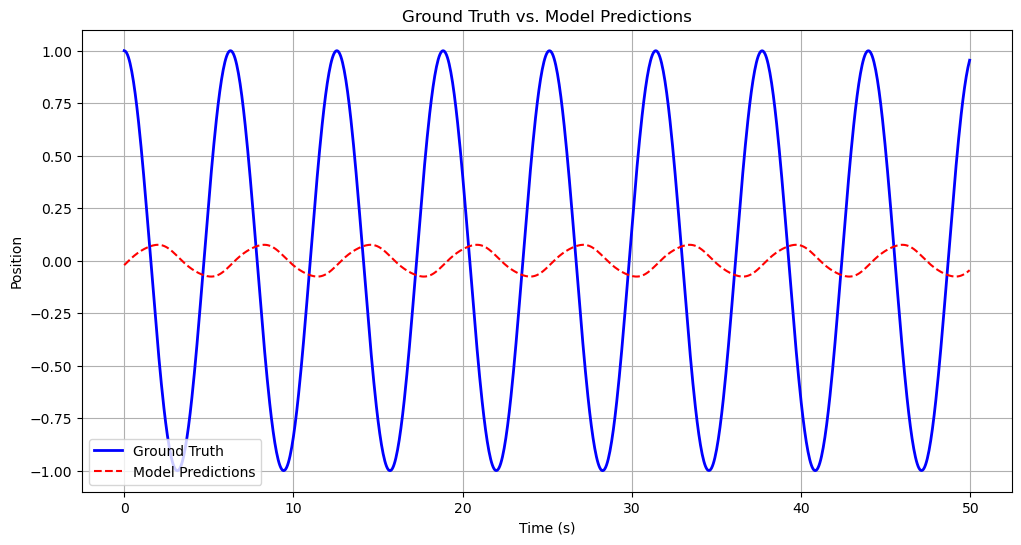

Final Root Mean Squared Error (RMSE) on the full dataset: 0.7236


In [11]:
# --- 1. Generate predictions using the trained model ---
predictions = model.predict(X)

# --- 2. Create a plot to compare predictions with the ground truth ---
plt.figure(figsize=(12, 6))

# Plot the ground truth (the actual data)
plt.plot(df['time'], y, label='Ground Truth', color='blue', linewidth=2)

# Plot the model's predictions
plt.plot(df['time'], predictions, label='Model Predictions', color='red', linestyle='--')

# Add labels and a title
plt.title('Ground Truth vs. Model Predictions')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Calculate the final error ---
final_mse = model.evaluate(X, y, verbose=0)
final_rmse = np.sqrt(final_mse)
print(f"Final Root Mean Squared Error (RMSE) on the full dataset: {final_rmse:.4f}")